## Example for eddy identification and tracking for daily data using py-eddy-tracker

### Remap ICON data onto IFS25 grid

#### Need target grid, which is 0.25deg IFS-grid that has inverted latitudes
#### Invert latitudes is needed because py-eddy-tracker would not work with latitudes going from north to south (default IFS 0.25deg grid), latitude must be strictly increasing. 
cdo -L -invertlat temp_IFS25_gridexample.nc IFS25_invertlat_gridexample.nc
#### Create weights from r2b9 (oce) to IFS25grid 
cdo -L -P 128 -genycon,IFS25_invertlat_gridexample.nc -setgrid,/pool/data/ICON/grids/public/mpim/0016/icon_grid_0016_R02B09_O.nc -selname,ssh erc1011_oce_2d_1mth_mean_20030201T000000Z.nc r2b9O_IFS25invertlat_yconremapweights.nc
#### Create weights from r2b8 (atm) to IFS25grid 
cdo -L -P 128 -genycon,IFS25_invertlat_gridexample.nc -setgrid,/pool/data/ICON/grids/public/mpim/0033/icon_grid_0033_R02B08_G.nc -selname,pr erc1011_atm_2d_1mth_mean_20030201T000000Z.nc r2b8G_IFS25invertlat_yconremapweights.nc

#### Remap SSH and SST onto IFS25 grid
cd ~/EERIE/remap \
remap_dm_yrmth_r2b9O_IFS25.job \
remap_dm_yrmth_r2b8G_IFS25.job \
submit_remapIFS25.sh

expid=erc1011 \
varname=ssh \
freqm=dm \
daterng=20020101-20021231 \
catalog=~/EERIE/intake/erc1011_200201-200812.json \
targetgrid=IFS25_invertlat_gridexample.nc \
remapwgt=r2b9O_IFS25invertlat_yconremapweights.nc \
srcgrid=/pool/data/ICON/grids/public/mpim/0016/icon_grid_0016_R02B09_O.nc

```
varfilelist=`./find_files --catalog_file=${catalog} ${varname} ${expid} --level_type=2d --time_reduction=mean --frequency=1day --time_range 2002-01-01 2002-02-01T23 `

varfile=${outdir}/${expid}_${varname}_${freqm}_${daterng}_IFS25.nc

cdo -L -P 128 -remap,${targetgrid},${remapwgt} -shifttime,-12hour -setgrid,${srcgrid} -select,name=${varname} [ ${varfilelist} ] ${varfile}
```




#### Eddy identification based on 0.25deg grid

In [1]:
from py_eddy_tracker.dataset.grid import RegularGridDataset
from datetime import datetime, timedelta
import numpy as np
from netCDF4 import Dataset
from matplotlib import pyplot as plt

#Read in example SSH data that has been mapped onto a 0.25deg regular grid.

expid='erc1011'
yyyy=2002
varname='ssh'
fq='dm'

daterng=str(yyyy)+'0101-'+str(yyyy)+'1231'
varfile='reg25/'+expid+'/'+varname+'/'+expid+'_'+varname+'_'+fq+'_'+daterng+'_IFS25.nc'

datearr=np.arange(datetime(yyyy,1,1), datetime(yyyy+1,1,1), timedelta(days=1)).astype(datetime)


In [2]:
def detection(varfile,varname,date,tt):
    wavelength=700  #choice of spatial cutoff for high pass filter in km
    step_ht=0.005 #intervals to search for closed contours (5mm in this case)
    g = RegularGridDataset(varfile, "lon", "lat", centered=True, indexs = dict(time=tt))
    # date = datearr[tt] # detect each timestep individually because of memory issues
    g.add_uv(varname)
    g.bessel_high_filter(varname, wavelength, order=1)
    
    a, c = g.eddy_identification(varname, "u", "v", 
    date,  # Date of identification
    step_ht,  # step between two isolines of detection (m)
    pixel_limit=(50, 400),  # Min and max pixel count for valid contour
    shape_error=30  # Error max (%) between ratio of circle fit and contour
    )
    return a,c,g



In [ ]:
#Save output
from netCDF4 import Dataset

outdir='reg25/'+expid+'eddytrack/'
for tt in np.arange(0,len(datearr),1):
    date = datearr[tt]
    print('Identifying daily eddies for '+date.strftime('%Y%m%d'))
    a_filtered, c_filtered, g_filtered = detection(varfile,varname,date,tt)
    with Dataset(date.strftime(outdir+expid+"_anticyclonic_"+fq+"_"+date.strftime('%Y%m%d')+".nc"), "w") as h:
        a_filtered.to_netcdf(h)
    with Dataset(date.strftime(outdir+expid+"_cyclonic_"+fq+"_"+date.strftime('%Y%m%d')+".nc"), "w") as h:
        c_filtered.to_netcdf(h)
    del a_filtered
    del c_filtered
    del g_filtered
    del date



In [3]:
# Test plot

tt=0
a0, c0, g0 = detection(varfile,varname,datearr[tt],tt)


No filtering above 85.000000 degrees of latitude
/work/mh0256/m300466/miniconda3/envs/t2/lib/python3.10/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [4]:
def start_axes(title):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
    ax.set_xlim(0,360), ax.set_ylim(-75,75)
    ax.set_aspect("equal")
    ax.set_title(title, weight="bold")
    return ax


def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))


/work/mh0256/m300466/miniconda3/envs/t2/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


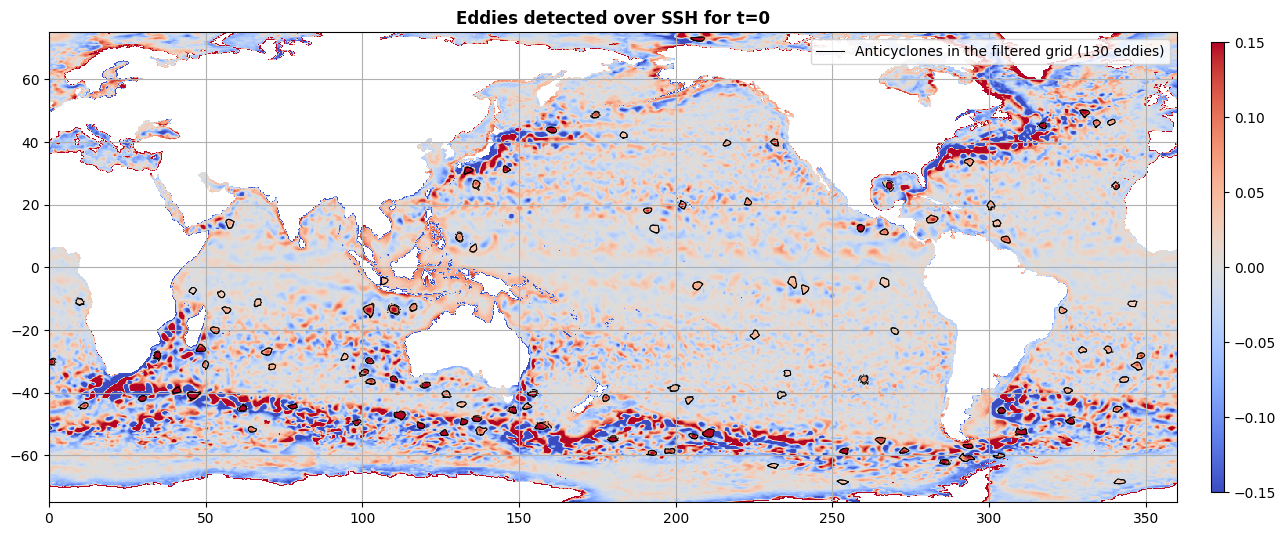

In [5]:
ax = start_axes("Eddies detected over SSH for t=0")
m = g0.display(ax, "ssh", vmin=-0.15, vmax=0.15)
a0.display(
    ax,
    lw=0.75,
    label="Anticyclones in the filtered grid ({nb_obs} eddies)",
    ref=-10,
    color="k",
)
ax.legend()
update_axes(ax, m)

#### Tracking eddies


In [6]:
import os 
import glob

from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.tracking import Correspondances

import numpy as np
from datetime import datetime, timedelta
from netCDF4 import Dataset
import xarray as xr


In [7]:
#Functions from eddy-tracking.py (aided by Malcolm Roberts)
def tracking(file_objects, previous_correspondance, eddy_type, zarr=False, nb_obs_min=10, raw=True, cmin=0.05, virtual=4):
    # %%
    # We run a tracking with a tracker which uses contour overlap, on first time step
    output_dir = os.path.dirname(previous_correspondance)
    class_kw = dict(cmin=cmin)
    if not os.path.isfile(previous_correspondance):
        c = Correspondances(
            datasets=file_objects, class_method=AreaTracker, 
            class_kw=class_kw, virtual=virtual
        )
        c.track()
        c.prepare_merging()
    else:
        c = Correspondances(
            datasets=file_objects, class_method=AreaTracker, 
            class_kw=class_kw, virtual=virtual,
            previous_correspondance=previous_correspondance
        )
        c.track()
        c.prepare_merging()
        c.merge()

    new_correspondance = previous_correspondance[:-3]+'_new.nc'
    with Dataset(new_correspondance, "w") as h:
        c.to_netcdf(h)

    try:
        # test can read new file, and then move to replace old file
        nc = Dataset(new_correspondance, 'r')
        os.rename(new_correspondance, previous_correspondance)
    except:
        raise Exception('Error opening new correspondance file '+new_correspondance)

    write_obs_files(c, raw, output_dir, zarr, eddy_type, nb_obs_min)
    

def write_obs_files(c, raw, output_dir, zarr, eddy_type, nb_obs_min):
    kw_write = dict(path=output_dir, zarr_flag=zarr, sign_type=eddy_type)

    fout = os.path.join(output_dir, eddy_type+'_untracked.nc')
    c.get_unused_data(raw_data=raw).write_file(
        filename=fout
    )

    short_c = c._copy()
    short_c.shorter_than(size_max=nb_obs_min)
    short_track = short_c.merge(raw_data=raw)

    if c.longer_than(size_min=nb_obs_min) is False:
        long_track = short_track.empty_dataset()
    else:
        long_track = c.merge(raw_data=raw)

    # We flag obs
    if c.virtual:
        long_track["virtual"][:] = long_track["time"] == 0
        long_track.normalize_longitude()
        long_track.filled_by_interpolation(long_track["virtual"] == 1)
        short_track["virtual"][:] = short_track["time"] == 0
        short_track.normalize_longitude()
        short_track.filled_by_interpolation(short_track["virtual"] == 1)

    print("Longer track saved have %d obs", c.nb_obs_by_tracks.max())
    print(
        "The mean length is %d observations for long track",
        c.nb_obs_by_tracks.mean(),
    )

    fout = os.path.join(output_dir, eddy_type+'_tracks.nc')
    long_track.write_file(filename=fout)
    fout = os.path.join(output_dir, eddy_type+'_short.nc')
    short_track.write_file(
        #filename="%(path)s/%(sign_type)s_track_too_short.nc", **kw_write
        filename=fout
    )



In [8]:
expid='erc1011'
# varname='ssh'
fq='dm'
yrrng=2002  #up to 2008
eddydir='reg25/'+expid+'/eddytrack/ssh/'+fq+'/'
tracker_dir=eddydir+'tracks/'
if not os.path.exists(tracker_dir):
    os.makedirs(tracker_dir)

nb_obs_min = 10 # minimum of 10 points in track to be considered a long trajectory
raw = False # 
cmin = 0.05 # minimum contour
virtual = 4 # number of consecutive timesteps with missing detection allowed
class_kw = dict(cmin=cmin)
zarr = False


In [ ]:
eddy_type='anticyclonic'
previous_correspondance = os.path.join(tracker_dir, expid+'_'+eddy_type+'_'+fq+'_correspondance.nc')
search = os.path.join(eddydir+expid+'_'+eddy_type+'_'+fq+'_'+yrrng+'????.nc')
print('search files ',search)
file_objects = sorted(glob.glob(search))
tracking(file_objects, previous_correspondance, eddy_type, zarr=zarr, nb_obs_min=nb_obs_min, raw=raw, cmin=cmin)


In [ ]:
eddy_type='cyclonic'  #need to include all changes with eddy_type
previous_correspondance = os.path.join(tracker_dir, expid+'_'+eddy_type+'_'+fq+'_correspondance.nc')
search = os.path.join(eddydir+expid+'_'+eddy_type+'_'+fq+'_'+yrrng+'????.nc')
print('search files ',search)
file_objects = sorted(glob.glob(search))
tracking(file_objects, previous_correspondance, eddy_type, zarr=zarr, nb_obs_min=nb_obs_min, raw=raw, cmin=cmin)


### Extract eddies along track for a given region, e.g. Agulhas leakage
For Agulhas leakage region, track the eddies, get track IDs where eddy last more than 60 days. \
Along the identified tracks, gather 2.5x2.5deg around eddy center and save. 



In [9]:
import os 
import numpy as np
from datetime import datetime, timedelta
import xarray as xr


In [10]:
rgn='AR'
mindays=60 #min number of days for tracked eddy
expid='erc1011'
fq='dm'
eddydir='reg25/'+expid+'/eddytrack/ssh/'+fq+'/'
tracker_dir=eddydir+'tracks/'

# eddy_type='cyclonic'
eddy_type='anticyclonic'

wavelength=700
dlon=2.5
dlat=2.5
res=0.25
npts=int(dlon/res) #number of points from centre


In [11]:
dscorres = xr.open_dataset(tracker_dir+expid+'_'+eddy_type+'_'+fq+'_correspondance.nc')
dstracks = xr.open_dataset(tracker_dir+eddy_type+'_tracks.nc')
dsshort = xr.open_dataset(tracker_dir+eddy_type+'_short.nc')
dsuntrack = xr.open_dataset(tracker_dir+eddy_type+'_untracked.nc')


In [12]:
#Get desired region [Agulhas rings and leakage]
ARidx = np.argwhere((dstracks.latitude.values<=-30) & (dstracks.latitude.values>=-45) & (dstracks.longitude.values>0) & (dstracks.longitude.values<25))

#Get track IDs for Agulhas rings, remove all duplicates
ARtrackid=np.array(sorted(list(set(dstracks.track.values[ARidx].squeeze()))))
print('Track IDs=',ARtrackid)

#Get number of obs for each track for Agulhas rings
trackIDs=dstracks.track.values
tracklen=[]
for ii in range(trackIDs.max()+1):
    tracklen.append(len(np.argwhere(trackIDs == ii)))
lentrack=np.array(tracklen)[ARtrackid]
print('No. of obs for each tracked ID =',lentrack)

#Remove tracks with less than minimum number of days 
newARtrackid=np.delete(ARtrackid,np.r_[np.argwhere(lentrack<mindays)])
print('Track IDs that last more than ',mindays,' days=',newARtrackid)
lentrack=np.array(tracklen)[newARtrackid]
print('No. of obs for each tracked ID =',lentrack)
del(tracklen)


Track IDs= [    4    29   125   127   133   171   176   179   219   263   280   286
   351   407   419   432   461   471   525   575   582   589   756   771
   793   811   828   870   976  1007  1024  1070  1104  1152  1161  1191
  1200  1212  1251  1314  1319  1321  1391  1392  1465  1520  1534  1535
  1725  1741  1752  1909  1913  1923  1935  2072  2101  2102  2113  2122
  2131  2134  2146  2231  2234  2277  2300  2328  2412  2443  2467  2563
  2567  2652  2717  2743  2863  2889  2944  2979  3020  3035  3135  3294
  3296  3297  3317  3337  3356  3421  3438  3472  3501  3521  3537  3621
  3666  3714  3730  3827  3854  3904  3933  3978  4007  4098  4153  4170
  4194  4202  4239  4323  4399  4404  4481  4504  4536  4621  4669  4670
  4692  4715  4785  4793  4802  4809  4836  4857  4898  4905  5088  5136
  5205  5208  5211  5250  5354  5421  5461  5463  5503  5557  5687  5708
  5713  5734  5760  6026  6049  6078  6148  6304  6311  6367  6422  6431
  6432  6476  6563  6630  6642  6776  67

In [13]:
def geteddy_alongtrack(dmvarfile,varname,loncen,latcen,dlon=2.5,dlat=2.5,npts=npts):
    npts2=npts*2
    loncen=round(loncen,2)
    latcen=round(latcen,2)
    dsvar=xr.open_dataset(dmvarfile)
    if varname=='rho':
        FIELD=dsvar['rhopoto']
    else:
        FIELD=dsvar[varname]
    lonmin=round(loncen-dlon,2)
    lonmax=round(loncen+dlon,2)
    latmin=round(latcen-dlat,2)
    latmax=round(latcen+dlat,2)
    print('eddy center='+str(loncen)+','+str(latcen))
    print('lonmin='+str(lonmin)+', lonmax='+str(lonmax)+', latmin='+str(latmin)+', latmax='+str(latmax))
    if (lonmin < 0) & (lonmax < 0):
        FIELDcomp=FIELD.sel(lon=slice(lonmin+360,lonmax+360),lat=slice(latmin,latmax))
    elif (lonmin < 0) & (lonmax >= 0):
        FIELDcomp=xr.concat([FIELD.sel(lon=slice(lonmin+360,360),lat=slice(latmin,latmax)),FIELD.sel(lon=slice(0,lonmax),lat=slice(latmin,latmax))],dim='lon')
    elif (lonmax > 360):
        FIELDcomp=xr.concat([FIELD.sel(lon=slice(lonmin,360),lat=slice(latmin,latmax)),FIELD.sel(lon=slice(0,lonmax-360),lat=slice(latmin,latmax))],dim='lon')
    else:
        FIELDcomp=FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
    if np.shape(FIELDcomp.squeeze())!=(npts2,npts2):
        print(np.shape(FIELDcomp))
        print('issue with '+dmvarfile)
        FIELDcomp=FIELDcomp[:,:npts2,:npts2]
    return FIELDcomp


#Note that this extract eddy tracks but does not normalise to eddy radius
def extract_eddytrack_raw(dstracks,tridx,varname='ssh',expid='erc1011',fq='dm',wavelength=700,dlon=2.5,dlat=2.5,res=0.25):
    npts=int(dlon/res)
    npts2=npts*2
    alongtrackidx=np.argwhere(dstracks.track.values==tridx)
    Reff=dstracks.effective_radius.values[alongtrackidx] #in metres
    loncen=dstracks.longitude.values[alongtrackidx]
    latcen=dstracks.latitude.values[alongtrackidx]
    timearr=dstracks.time.values[alongtrackidx].flatten()
    date_arr=[]
    FIELDcomp=[]
    for tt in range(len(timearr)):
        date_arr.append(datetime.strptime(str(timearr[tt])[:10], '%Y-%m-%d'))
        date=date_arr[tt]
        # print('Extracting for '+date.strftime('%Y%m%d'))
        #Get high pass filtered classified data
        outdir='reg25/'+expid+'/eddytrack/'
        if varname=='rho' or varname=='to':
            dmvarfile=outdir+varname+'/sm'+str(int(wavelength))+'km/'+expid+'_'+varname+'_1_'+fq+'_'+date.strftime('%Y%m%d')+'_IFS25_hp'+str(wavelength)+'.nc'
        else:
            dmvarfile=outdir+varname+'/sm'+str(int(wavelength))+'km/'+expid+'_'+varname+'_'+fq+'_'+date.strftime('%Y%m%d')+'_IFS25_hp'+str(wavelength)+'.nc'
        FIELDcomp.append(geteddy_alongtrack(dmvarfile,varname,loncen[tt][0],latcen[tt][0],dlon=dlon,dlat=dlat,npts=npts))
        del(dmvarfile)

    for ii in range(len(FIELDcomp)):
        if np.shape(FIELDcomp[ii].squeeze())!=(npts2,npts2):
            print(np.shape(FIELDcomp[ii].squeeze()))
            # print('issue with track#'+str(alongtrackidx))
        FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)
    
    return alongtrackidx, date_arr, FIELDcomp, FIELDcomp[0].attrs

#Note it is not normalized to eddy radius
def create_eddycomp_dataset(SSHcomp,date_arr,npts,res,SSHattrs,tridx,alongtrackidx,dstracks):
    compSSH=xr.DataArray(data=np.array(SSHcomp).squeeze(),
                 coords={'time':date_arr, 'y':np.arange(-npts,npts)*res, 'x':np.arange(-npts,npts)*res},
                 dims=['time','y','x'],name='ssh',attrs=SSHattrs)
    dsSSH=compSSH.to_dataset()
    # dsSSH=dsSSH.assign({'eddytrackID':tridx})
    cpts=dstracks.uavg_profile.shape[1]
    dsSSH=dsSSH.merge(xr.DataArray(data=tridx,name='eddytrackID',attrs={'long name':'ID of eddy track'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=alongtrackidx.flatten(),coords={'time':date_arr},dims=['time'],name='track'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.longitude.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='lon',attrs={'long name':'longitude of eddy centre'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.latitude.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='lat',attrs={'long name':'latitude of eddy centre'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.effective_radius.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='effective_radius',attrs={'long name':'Effective radius of eddy'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.effective_area.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='effective_area',attrs={'long name':'Effective area of eddy'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.amplitude.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='amplitude',attrs={'long name':'Amplitude of eddy'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.time.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='date_time',attrs={'long name':'date and time in datetime64'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.observation_number.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='n',attrs={'long name':'days since first detection'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.uavg_profile.values[alongtrackidx].squeeze(),
                                   coords={'time':date_arr,'contour':np.arange(0,cpts)},dims=['time','contour'],name='uavg_profile'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.speed_average.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='speed_average'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.speed_area.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='speed_area'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.effective_contour_longitude.values[alongtrackidx].squeeze(),
                                   coords={'time':date_arr,'contour':np.arange(0,cpts)},dims=['time','contour'],name='contour_lon_e'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.effective_contour_latitude.values[alongtrackidx].squeeze(),
                                   coords={'time':date_arr,'contour':np.arange(0,cpts)},dims=['time','contour'],name='contour_lat_e'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.effective_radius.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='radius_e'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.num_point_e.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='num_point_e'))
    dsSSH=dsSSH.merge(xr.DataArray(data=np.array(dstracks.effective_contour_shape_error.values[alongtrackidx].flatten(),dtype='float32'),coords={'time':date_arr},dims=['time'],name='shape_error_e'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.speed_contour_longitude.values[alongtrackidx].squeeze(),
                                   coords={'time':date_arr,'contour':np.arange(0,cpts)},dims=['time','contour'],name='contour_lon_s'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.speed_contour_latitude.values[alongtrackidx].squeeze(),
                                   coords={'time':date_arr,'contour':np.arange(0,cpts)},dims=['time','contour'],name='contour_lat_s'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.speed_radius.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='radius_s'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.num_point_s.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='num_point_s'))
    dsSSH=dsSSH.merge(xr.DataArray(data=np.array(dstracks.speed_contour_shape_error.values[alongtrackidx].flatten(),dtype='float32'),coords={'time':date_arr},dims=['time'],name='shape_error_s'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.num_contours.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='nb_contour_selected'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.longitude_max.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='lon_max'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.latitude_max.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='lat_max'))
    # dsSSH=dsSSH.merge(xr.DataArray(data=eddies_area_tracker.height_external_contour[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='height_external_contour'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.inner_contour_height.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='height_inner_contour'))
    # dsSSH=dsSSH.merge(xr.DataArray(data=eddies_area_tracker.height_max_speed_contour[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='height_max_speed_contour'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.cost_association.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='cost_association'))
    # dsSSH=dsSSH.merge(xr.DataArray(data=eddies_area_tracker.virtual[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='virtual'))

    return dsSSH


#Note it is not normalized to eddy radius
def appendto_eddycomp_dataset(dsSSH,varname,FIELDcomp,date_arr,npts,res,FIELDattrs):
    dsSSH=dsSSH.merge(xr.DataArray(data=np.array(FIELDcomp).squeeze(),
                 coords={'time':date_arr, 'y':np.arange(-npts,npts)*res, 'x':np.arange(-npts,npts)*res},
                 dims=['time','y','x'],name=varname,attrs=FIELDattrs))
    return dsSSH




In [ ]:
#Extract composites along track and save to file

for tridx in newARtrackid:
    print('Extracting for eddy track ',tridx)
    #Extract tracked eddies
    alongtrackidx, date_arr, SSHcomp, SSHattrs = extract_eddytrack_raw(dstracks,tridx,varname='ssh',wavelength=wavelength,dlon=dlon,dlat=dlat,res=res)
    
    #Put SSH composite into xarray
    dsSSH=create_eddycomp_dataset(SSHcomp,date_arr,npts,res,SSHattrs,tridx,alongtrackidx,dstracks)
   
    fileout=tracker_dir+expid+'_'+rgn+'_'+eddy_type+'_'+str(dlon)+'x'+str(dlat)+'deg_trackID_'+str(tridx)+'.nc'
    dsSSH.to_netcdf(fileout)

